## Diagonal integration with label annotation

A integration task is called [diagonal integration](https://www.nature.com/articles/s41587-021-00895-7) if different modalities share no correspondence information, either among cells or features, e.g., scATAC peaks and scRNA genes, we can use label annotations as prior information to improve the performance.

In [1]:
import uniport as up
import scanpy as sc
import episcanpy as epi
up.__version__

'1.1.0'

In [2]:
adata_rna = sc.read('mouse_spleen/rna.h5ad', backup_url='ftp://ngs.sanger.ac.uk/production/teichmann/MultiMAP/rna.h5ad')
adata_atac = sc.read('mouse_spleen/atac-peaks.h5ad', backup_url='ftp://ngs.sanger.ac.uk/production/teichmann/MultiMAP/atac-peaks.h5ad')

In [3]:
print(adata_rna)
print(adata_atac)

AnnData object with n_obs × n_vars = 4382 × 13575
    obs: 'cell_type', 'source'
AnnData object with n_obs × n_vars = 3166 × 126590
    obs: 'cell_type', 'source'


In [4]:
adata_atac.obs['domain_id'] = 0
adata_atac.obs['domain_id'] = adata_atac.obs['domain_id'].astype('category')

adata_rna.obs['domain_id'] = 1
adata_rna.obs['domain_id'] = adata_rna.obs['domain_id'].astype('category')

Preprocess scATAC peaks using `up.TFIDF_LSI`.

AnnData object with n_obs × n_vars = 3166 × 126590
    obs: 'cell_type', 'source', 'domain_id'
    obsm: 'X_lsi'


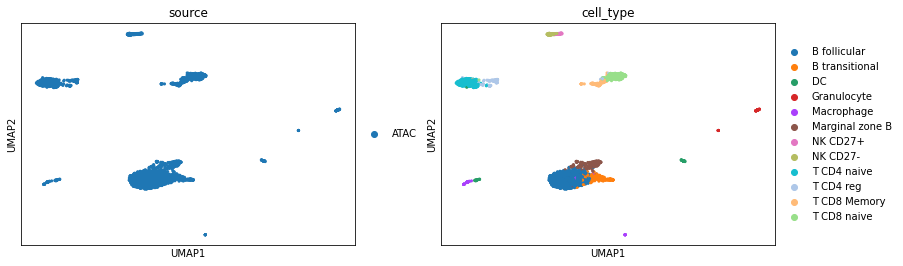

In [5]:
adata_atac.X[adata_atac.X>1] = 1
up.TFIDF_LSI(adata_atac)
print(adata_atac)
# epi.pp.select_var_feature(adata_atac, nb_features=2000, show=False, copy=False)
up.batch_scale(adata_atac, use_rep='X_lsi')

adata_atac_copy = adata_atac.copy()
sc.pp.neighbors(adata_atac_copy, use_rep="X_lsi")
sc.tl.umap(adata_atac_copy, min_dist=0.1)
sc.pl.umap(adata_atac_copy, color=['source', 'cell_type'])

AnnData object with n_obs × n_vars = 4382 × 2000
    obs: 'cell_type', 'source', 'domain_id'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'


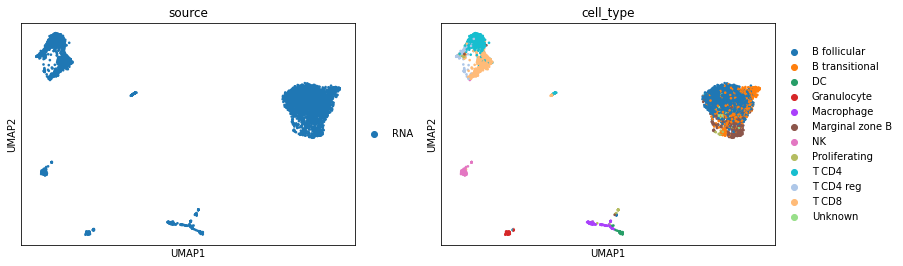

In [6]:
sc.pp.normalize_total(adata_rna)
sc.pp.log1p(adata_rna)
sc.pp.highly_variable_genes(adata_rna, n_top_genes=2000, inplace=False, subset=True)
sc.pp.pca(adata_rna)
up.batch_scale(adata_rna)
print(adata_rna)

adata_rna_copy = adata_rna.copy()
sc.pp.neighbors(adata_rna_copy)
sc.tl.umap(adata_rna_copy, min_dist=0.1)
sc.pl.umap(adata_rna_copy, color=['source', 'cell_type'])

Diagonal integration without prior information.

In [7]:
adata = up.Run(adatas=[adata_atac, adata_rna], use_rep=['X_lsi','X'], mode='d', iteration=20000)

2022-05-13 23:03:25,229 - root - INFO - model
VAE(
  (encoder): Encoder(
    (enc): ModuleList(
      (0): NN(
        (net): ModuleList(
          (0): Block(
            (fc): Linear(in_features=49, out_features=1024, bias=True)
            (norm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act): ReLU()
          )
        )
      )
      (1): NN(
        (net): ModuleList(
          (0): Block(
            (fc): Linear(in_features=2000, out_features=1024, bias=True)
            (norm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act): ReLU()
          )
        )
      )
    )
    (mu_enc): ModuleList(
      (0): NN(
        (net): ModuleList(
          (0): Block(
            (fc): Linear(in_features=1024, out_features=16, bias=True)
          )
        )
      )
      (1): NN(
        (net): ModuleList(
          (0): Block(
            (fc): Linear(in_features=1024, out_features

Dataset 0: ATAC
AnnData object with n_obs × n_vars = 3166 × 126590
    obs: 'cell_type', 'source', 'domain_id'
    obsm: 'X_lsi'
Dataset 1: RNA
AnnData object with n_obs × n_vars = 4382 × 2000
    obs: 'cell_type', 'source', 'domain_id'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
Reference dataset is dataset 1




Epochs: 100%|█| 690/690 [12:08<00:00,  1.06s/it, recon_loss=-176.973,kl_loss=25.


... storing 'cell_type' as categorical
... storing 'source' as categorical


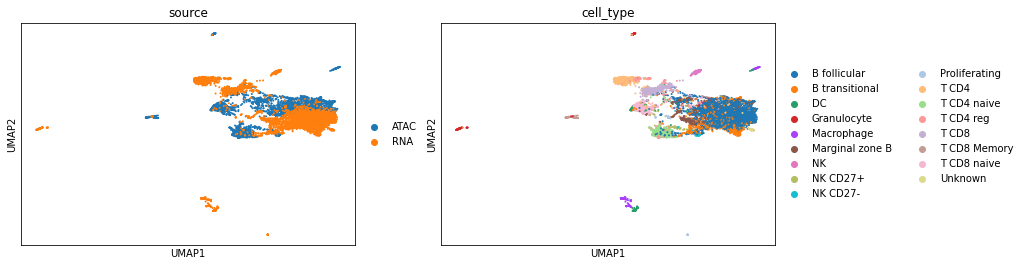

In [8]:
sc.pp.neighbors(adata, use_rep='latent')
sc.tl.umap(adata, min_dist=0.1)
sc.pl.umap(adata, color=['source', 'cell_type'])

Construct prior correspondence information with label annotation.

In [9]:
alpha=3
prior = up.get_prior(adata_atac.obs['cell_type'].values, adata_rna.obs['cell_type'].values, alpha=alpha)

Diagonal integration with correspondence information.

In [10]:
adata = up.Run(adatas=[adata_atac, adata_rna], use_rep=['X_lsi','X'], prior=[prior], mode='d', iteration=20000, lambda_ot=5)

2022-05-13 23:15:48,105 - root - INFO - model
VAE(
  (encoder): Encoder(
    (enc): ModuleList(
      (0): NN(
        (net): ModuleList(
          (0): Block(
            (fc): Linear(in_features=49, out_features=1024, bias=True)
            (norm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act): ReLU()
          )
        )
      )
      (1): NN(
        (net): ModuleList(
          (0): Block(
            (fc): Linear(in_features=2000, out_features=1024, bias=True)
            (norm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act): ReLU()
          )
        )
      )
    )
    (mu_enc): ModuleList(
      (0): NN(
        (net): ModuleList(
          (0): Block(
            (fc): Linear(in_features=1024, out_features=16, bias=True)
          )
        )
      )
      (1): NN(
        (net): ModuleList(
          (0): Block(
            (fc): Linear(in_features=1024, out_features

Dataset 0: ATAC
AnnData object with n_obs × n_vars = 3166 × 126590
    obs: 'cell_type', 'source', 'domain_id'
    obsm: 'X_lsi', 'latent'
Dataset 1: RNA
AnnData object with n_obs × n_vars = 4382 × 2000
    obs: 'cell_type', 'source', 'domain_id'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca', 'latent'
    varm: 'PCs'
Reference dataset is dataset 1




Epochs: 100%|█| 690/690 [17:28<00:00,  1.52s/it, recon_loss=-164.444,kl_loss=26.


... storing 'cell_type' as categorical
... storing 'source' as categorical


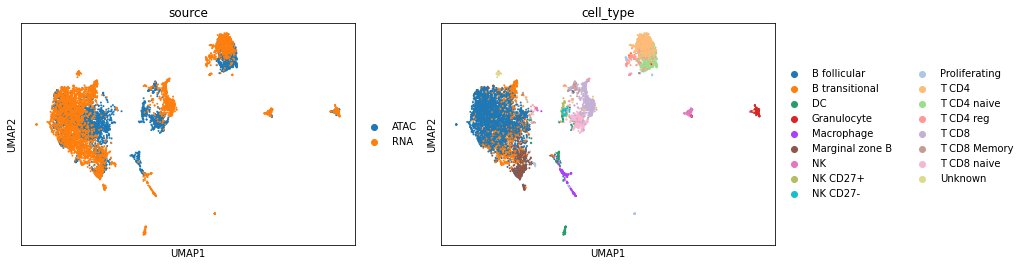

In [11]:
sc.pp.neighbors(adata, use_rep='latent')
sc.tl.umap(adata, min_dist=0.1)
sc.pl.umap(adata, color=['source', 'cell_type'])